<a href="https://colab.research.google.com/github/Kontrabass2018/DeepLearningGPU/blob/main/GPU_computing_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-12-13 07:58:45 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package CUDA...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, skylake-avx512)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_NUM_THREADS = 2


In [ ]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

  470.139 ms (2 allocations: 32.00 MiB)


In [2]:
# only first time!
using Pkg
#Pkg.add("CUDA")
#Pkg.add("Flux")
Pkg.add("HDF5")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed MicrosoftMPI_jll ── v10.1.4+3
   Installed MPIPreferences ──── v0.1.11
   Installed libaec_jll ──────── v1.1.2+0
   Installed OpenSSL_jll ─────── v3.0.15+1
   Installed OpenMPI_jll ─────── v4.1.6+0
   Installed Hwloc_jll ───────── v2.11.2+1
   Installed MPICH_jll ───────── v4.2.3+0
   Installed MPItrampoline_jll ─ v5.5.1+0
   Installed HDF5_jll ────────── v1.14.3+3
   Installed HDF5 ────────────── v0.17.2
    Updating `~/.julia/environments/v1.8/Project.toml`
  [f67ccb44] + HDF5 v0.17.2
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [f67ccb44] + HDF5 v0.17.2
  [3da0fdf6] + MPIPreferences v0.1.11
  [0234f1f7] + HDF5_jll v1.14.3+3
  [e33a78d0] + Hwloc_jll v2.11.2+1
  [7cb0a576] + MPICH_jll v4.2.3+0
  [f1f71cc9] + MPItrampoline_jll v5.5.1+0
  [9237b28f] + MicrosoftMPI_jll v10.1.4+3
⌅ [fe0851c0] + OpenMPI_jll v4.1.6+0
  [458c3c95] + OpenSSL_jll v3.0.15+1
  [477f73a3] + libae

In [ ]:
using CUDA
using Flux


┌ Error: cuDNN is not available for your platform (x86_64-linux-gnu-libgfortran5-cxx11-libstdcxx29-cuda+none-julia_version+1.8.2)
└ @ cuDNN ~/.julia/packages/cuDNN/dAoBn/src/cuDNN.jl:160


## Importing Data

In [3]:
using Random
using HDF5
function load_tcga_data(infilename; shfl = true)
    infile = h5open(infilename)
    TCGA_data = infile["data"][:,:]
    labs = string.(infile["labels"][:])
    samples = string.(infile["samples"][:])
    genes = string.(infile["genes"][:])
    biotypes = string.(infile["biotypes"][:])
    close(infile)
    ids = collect(1:size(labs)[1])
    shfl && (ids = shuffle(ids))
    return TCGA_data[ids,:], labs[ids], samples[ids], genes, biotypes
end

function fetch_data(filename; shfl = true)
    if !(filename in readdir("."))
        # Define the URL`
        tcga_data_url = "https://bioinfo.iric.ca/~sauves/VARIA/$filename"

        # Escape the URL to handle special characters
        escaped_url = Base.shell_escape(tcga_data_url)

        # Construct and execute the wget command
        command = `wget $escaped_url`
        run(command)
    end
    load_tcga_data(filename; shfl = shfl)

end

fetch_data (generic function with 1 method)

In [4]:
infilename = "TCGA_19962_TPM_lab.h5"
TCGA_data, labels, samples, genes, biotypes = fetch_data(infilename);

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 90000K .......... .......... .......... .......... ..........  5% 79.0M 48s
 90050K .......... .......... .......... .......... ..........  5%  127M 48s
 90100K .......... .......... .......... .......... ..........  5% 67.9M 48s
 90150K .......... .......... .......... .......... ..........  5%  119M 48s
 90200K .......... .......... .......... .......... ..........  5% 98.8M 48s
 90250K .......... .......... .......... .......... ..........  5% 56.4M 48s
 90300K .......... .......... .......... .......... ..........  5%  113M 48s
 90350K .......... .......... .......... .......... ..........  5%  113M 48s
 90400K .......... .......... .......... .......... ..........  5% 95.6M 48s
 90450K .......... .......... .......... .......... ..........  5%  108M 48s
 90500K .......... .......... .......... .......... ..........  5%  108M 48s
 90550K .......... .......... .......... .......... ..........  5% 39.7M 48

([1.1113162929275264 0.01123201031936597 … 0.003460532109506489 0.08167128729092382; 1.5762169191085895 0.0 … 0.0 0.545665787120142; … ; 1.6980927125861436 0.20623202432629986 … 0.02934318751910664 0.2555137128195334; 1.5529965499794953 0.18934992433919778 … 0.016239191042638865 0.338177499296536], ["TCGA-HNSC", "TCGA-READ", "TCGA-LUSC", "TCGA-MESO", "TCGA-LIHC", "TCGA-PRAD", "TCGA-LGG", "TCGA-KIRC", "TCGA-HNSC", "TCGA-KIRP"  …  "TCGA-KIRP", "TCGA-KIRP", "TCGA-PRAD", "TCGA-LIHC", "TCGA-BRCA", "TCGA-BRCA", "TCGA-COAD", "TCGA-STAD", "TCGA-THCA", "TCGA-COAD"], ["d9e8c707-e61a-4813-8dc0-2472e9ccf12b", "a424bfe7-5518-4c80-83c8-709a34320bc7", "f1a1bbf9-4751-4fb4-8a2b-19f8d4ba57bd", "1c848577-c3a4-4830-abfa-549992172396", "1724c96a-2aa3-43d4-992a-08af948c0f45", "94d6675e-27ae-4f34-9d53-6e19238eb01d", "c0d47e0f-4918-4e06-9db6-201671b1259c", "c3cc716b-1b9c-4e73-9a40-f1f891a17c2d", "97c3c5dc-5540-4713-805e-4d98fd8c03ad", "6eb010c4-c906-42d4-894d-8b47de90e023"  …  "e8c22f36-20ad-469f-8eac-fb52d8b

# Coding an SVD implementation in Julia on GPU

SVD algorithm as presented in this article https://arxiv.org/pdf/2209.04626

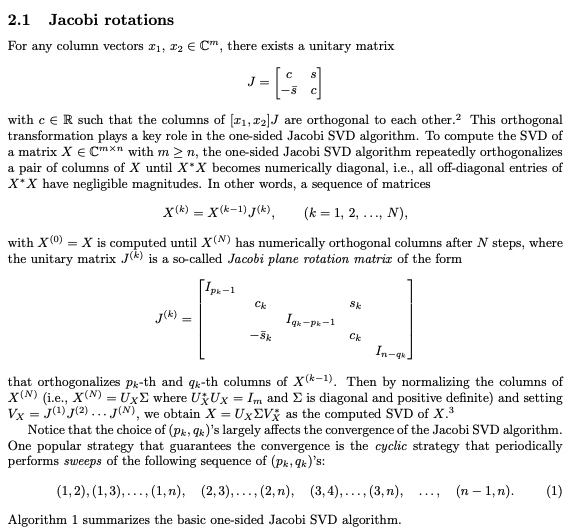

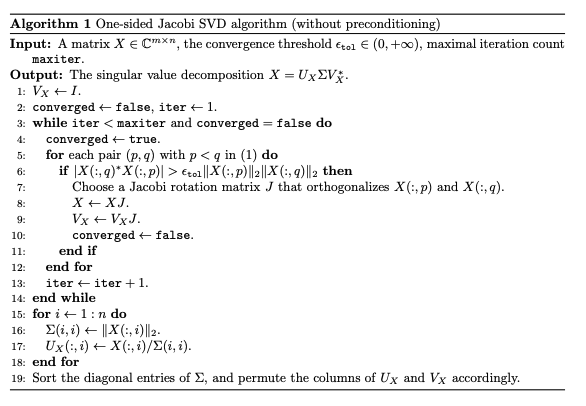

These formulas help determine the angle to use for each iteration. From the paper Drmac and Veselic 2007 (https://www.fernuni-hagen.de/MATHPHYS/veselic/downloads/j0.pdf)

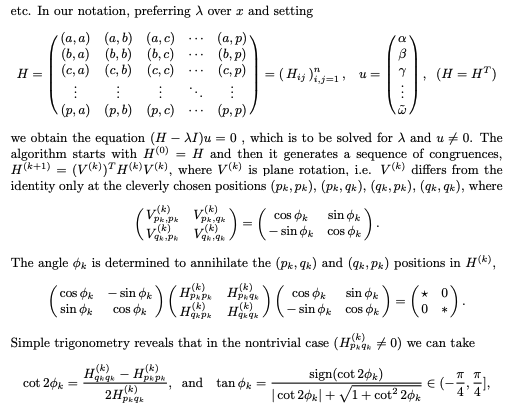

## CPU implementation

In [5]:


using Statistics
using LinearAlgebra

function fit_transform_pca(X, outdim)
    x_means =  mean(X, dims =2 )
    Z = X .- x_means
    U, S, V = svd(Z,full=true);
    Matrix(U[:, sortperm(S, rev=true)[1:outdim]]') * Z
end
function fit_pca(X, outdim)
    x_means =  mean(X, dims =2 )
    Z = X .- x_means
    U, S, V = svd(Z,full=true);
    return Matrix(U[:, sortperm(S, rev=true)[1:outdim]]')
end
function transform_pca(X, P)
    x_means =  mean(X, dims =2 )
    Z = X .- x_means
    P * Z
end




transform_pca (generic function with 1 method)

In [ ]:
X_tr = fit_transform_pca(TCGA_data',500)

## GPU implementation

In [ ]:
X = TCGA_data[:,biotypes .== "protein_coding"] |>gpu

In [ ]:
function fit_transform_pca(X, outdim, device=gpu)
    x_means =  mean(X |> device, dims =2 )
    Z = X .- x_means
    U, S, V = svd_jacobi(Z,full=true);
    Matrix(U[:, sortperm(S, rev=true)[1:outdim]]') * Z
end

fit_transform_pca (generic function with 2 methods)

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />